### In this analysis, I use a linear regression model to predict the Weight of a given fish from a market based on its other characteristics.

## Imports and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statistics import mean 

%matplotlib inline

In [2]:
df = pd.read_csv('Fish_Data.csv', index_col=False)
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## Preliminary Exploratory Data Analysis

In [3]:
df['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

In [4]:
df.groupby('Species')['Weight'].mean()

Species
Bream        617.828571
Parkki       154.818182
Perch        382.239286
Pike         718.705882
Roach        152.050000
Smelt         11.178571
Whitefish    531.000000
Name: Weight, dtype: float64

### I notice that the three different 'Length' meausurements all have very similar distributions by fish species. It's likely that I will find strong correlation between these variables.

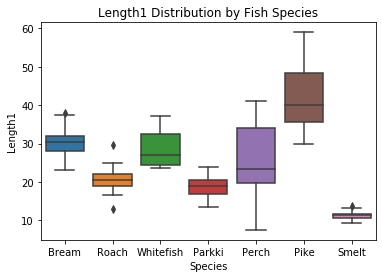

In [5]:
ax = sns.boxplot(x="Species", y="Length1", data=df).set_title('Length1 Distribution by Fish Species')

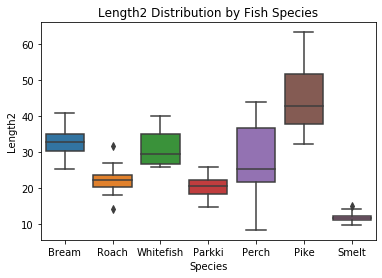

In [6]:
ax = sns.boxplot(x="Species", y="Length2", data=df).set_title('Length2 Distribution by Fish Species')

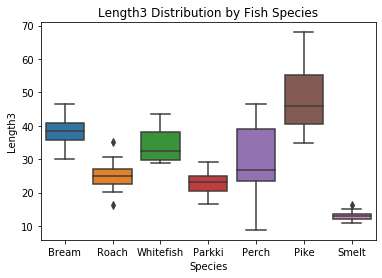

In [7]:
ax = sns.boxplot(x="Species", y="Length3", data=df).set_title('Length3 Distribution by Fish Species')

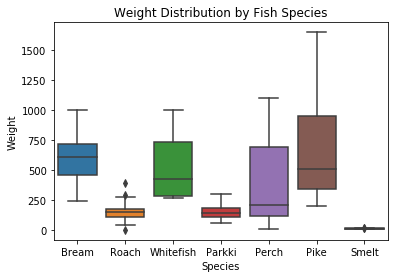

In [8]:
ax = sns.boxplot(x="Species", y="Weight", data=df).set_title('Weight Distribution by Fish Species')

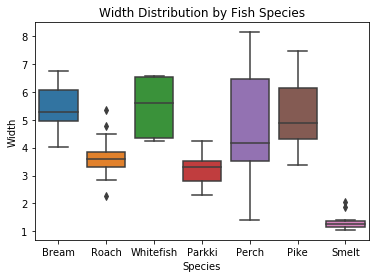

In [9]:
ax = sns.boxplot(x="Species", y="Width", data=df).set_title('Width Distribution by Fish Species')

### All of the continuous independent variables are strongly (positively) linearly correlated with the DV (Weight), so a Linear Model framework makes sense.

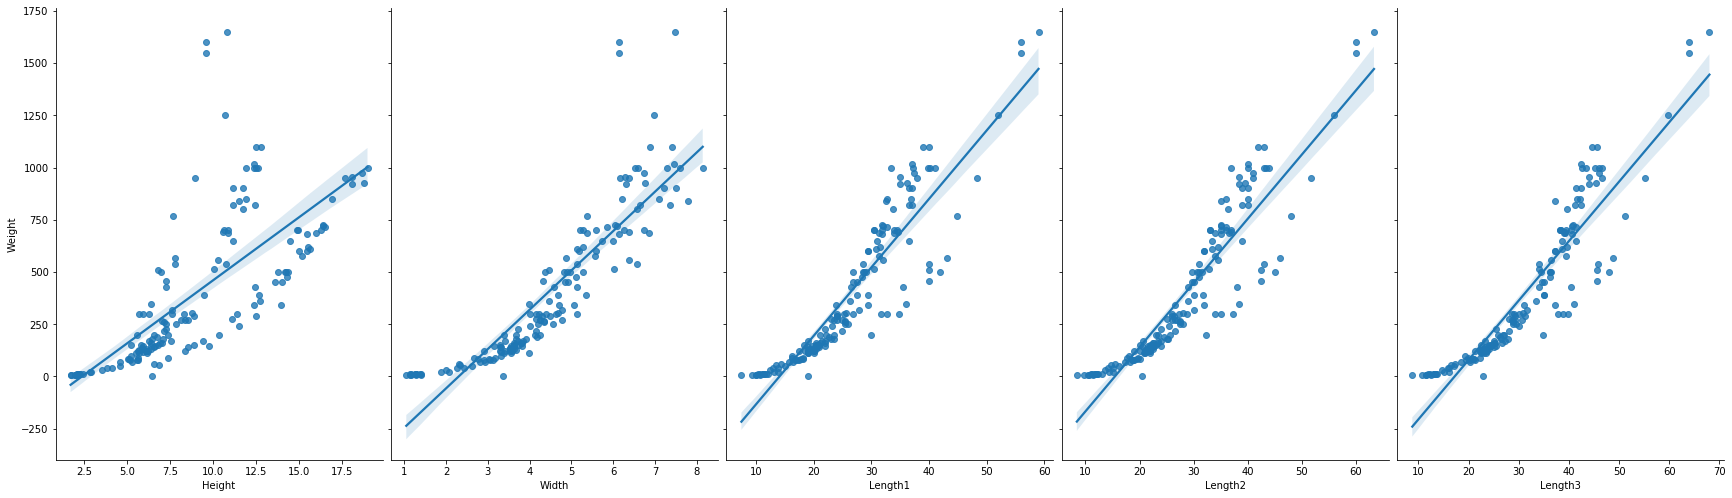

In [10]:
sns.pairplot(df, x_vars=['Height','Width','Length1', 'Length2', 'Length3'], y_vars='Weight', height=7, aspect=0.7, kind='reg', diag_kind = None);

### First I make a correlation coefficient table for all of the continuous independent variables. As you can see, there is high correlation amongst all variables, especially between pairs of the 'Length' variables

In [11]:
df[['Height', 'Width', 'Length1', 'Length2', 'Length3']].corr()

,Height,Width,Length1,Length2,Length3
Height,1.000000,0.792881,0.625378,0.640441,0.703409
Width,0.792881,1.000000,0.867050,0.873547,0.878520
Length1,0.625378,0.867050,1.000000,0.999517,0.992031
Length2,0.640441,0.873547,0.999517,1.000000,0.994103
Length3,0.703409,0.878520,0.992031,0.994103,1.000000


## Dummy the categorical variable "Species"

In [12]:
Species_dummies = pd.get_dummies(df.Species, prefix='Species').iloc[:, 1:]
Species_dummies.head()

,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [13]:
df = pd.concat([df, Species_dummies], axis=1)
df.drop('Species', axis=1, inplace = True)
df.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,0,0,0,0,0,0


### Calculate Variance Inflaction Factors (VIFs) for all independent variables

In [14]:
X = df.loc[:, df.columns != 'Weight']

vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

              feature           VIF
0             Length1  18095.288475
1             Length2  30522.367427
2             Length3   7960.777533
3              Height    235.486610
4               Width    182.874185
5      Species_Parkki      1.272513
6       Species_Perch      8.913123
7        Species_Pike     15.338391
8       Species_Roach      2.747195
9       Species_Smelt      1.840413
10  Species_Whitefish      1.747763


### Since there are many variables with high VIF, I now begin the iterative process of excluding the variable with the highest VIF until all variables have a VIF < 5. 

In [15]:
X2 = X.loc[:, X.columns != 'Length2']

vif_data = pd.DataFrame() 
vif_data["feature"] = X2.columns 
vif_data["VIF"] = [variance_inflation_factor(X2.values, i) 
                          for i in range(len(X2.columns))] 
  
print(vif_data)

             feature          VIF
0            Length1  3938.011102
1            Length3  4851.453432
2             Height   231.280402
3              Width   181.929945
4     Species_Parkki     1.233832
5      Species_Perch     6.556086
6       Species_Pike    15.284881
7      Species_Roach     2.718007
8      Species_Smelt     1.791291
9  Species_Whitefish     1.644230


In [16]:
X3 = X2.loc[:, X2.columns != 'Length3']

vif_data = pd.DataFrame() 
vif_data["feature"] = X3.columns 
vif_data["VIF"] = [variance_inflation_factor(X3.values, i) 
                          for i in range(len(X3.columns))] 
  
print(vif_data)

             feature         VIF
0            Length1  208.290678
1             Height   64.645153
2              Width  157.135124
3     Species_Parkki    1.113231
4      Species_Perch    6.406321
5       Species_Pike   12.789017
6      Species_Roach    1.949318
7      Species_Smelt    1.638303
8  Species_Whitefish    1.513075


In [17]:
X4 = X3.loc[:, X3.columns != 'Length1']

vif_data = pd.DataFrame() 
vif_data["feature"] = X4.columns 
vif_data["VIF"] = [variance_inflation_factor(X4.values, i) 
                          for i in range(len(X4.columns))] 
  
print(vif_data)

             feature        VIF
0             Height  51.242084
1              Width  80.466771
2     Species_Parkki   1.104362
3      Species_Perch   5.569874
4       Species_Pike   2.996380
5      Species_Roach   1.713386
6      Species_Smelt   1.092319
7  Species_Whitefish   1.477491


## Model Final Features List

In [18]:
X5 = X4.loc[:, X4.columns != 'Width']
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X5.columns 
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X5.values, i) 
                          for i in range(len(X5.columns))] 
  
print(vif_data)

             feature       VIF
0             Height  1.789162
1     Species_Parkki  1.100699
2      Species_Perch  1.394478
3       Species_Pike  1.115283
4      Species_Roach  1.102161
5      Species_Smelt  1.007788
6  Species_Whitefish  1.068753


## Model 

In [19]:
lm1 = smf.ols(formula='Weight ~ Height + Species_Parkki + Species_Perch + Species_Pike + Species_Roach + Species_Smelt + Species_Whitefish', data=df).fit()

lm1.params

Intercept           -1210.602453
Height                120.424525
Species_Parkki        286.124588
Species_Perch         646.079821
Species_Pike         1000.381176
Species_Roach         556.434945
Species_Smelt         955.718520
Species_Whitefish     534.085670
dtype: float64

In [20]:
lm1.conf_int()

,0,1
Intercept,-1361.993825,-1059.211081
Height,110.863016,129.986034
Species_Parkki,180.067728,392.181447
Species_Perch,557.217542,734.942101
Species_Pike,896.745465,1104.016887
Species_Roach,448.464759,664.405131
Species_Smelt,807.930299,1103.506740
Species_Whitefish,411.491527,656.679813


In [21]:
lm1.pvalues

Intercept            8.296139e-34
Height               2.695906e-55
Species_Parkki       3.505134e-07
Species_Perch        4.811644e-30
Species_Pike         4.714980e-42
Species_Roach        7.288370e-19
Species_Smelt        8.304851e-26
Species_Whitefish    9.059030e-15
dtype: float64

## Model R-Squared

In [22]:
lm1.rsquared

0.8767212600952883

### All relations between Independent variables and the Dependent variable are significant, and our R-Squared is strong (~0.88)

## Model Summary

In [23]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Weight   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     153.4
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           2.63e-65
Time:                        17:08:16   Log-Likelihood:                -993.69
No. Observations:                 159   AIC:                             2003.
Df Residuals:                     151   BIC:                             2028.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1210.6025     76.623    -15.799      0.000   -1361.994   -1059.211
Height              120.4245      4.839     24.885      0.000     110.863     129.986
Species_Parkki      286.1246     53.678      5.330      0.000     180.068     392.181
Species_Perch       646.0798     44.975     14.365      0.000     557.218     734.942
Species_Pike       1000.3812     52.453     19.072      0.000     896.745    1104.017
Species_Roach       556.4349     54.646     10.182      0.000     448.465     664.405
Species_Smelt       955.7185     74.799     12.777      0.000     807.930    1103.507
Species_Whitefish   534.0857     62.048      8.608      0.000     411.492     656.680
==============================================================================
Omnibus:                       92.357   Durbin-Watson:                   0.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.976
Skew:                           2.043   Prob(JB):                    1.29e-133
Kurtosis:                      11.699   Cond. No.                         135.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Next I will use the LinearRegression model from sci-kit learn so I can split the data into different train/test splits. Below, I test 5 different models on 5 different training data sets, and find the average RMSE and R-Squared scores of all the models.

In [24]:
X = df[['Height', 'Species_Parkki','Species_Perch', 'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish']]
y = df['Weight']

RMSE_list = []
R2_Score_list = []
for r in [1, 10, 60, 190, 310]:

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=r)

    lm1sk = LinearRegression()

    lm1sk.fit(X_train, y_train)

    y_pred = lm1sk.predict(X_test)
    
    ## Print r
    print("Random State: " + str(r))

    # Print RMSE
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print("RMSE: ", RMSE)
    RMSE_list.append(RMSE)

    # Print R-Squared
    R2_Score = np.sqrt(metrics.r2_score(y_test, y_pred))
    print("R2_Score: ", R2_Score)
    R2_Score_list.append(R2_Score)

print("")
print("\033[1mAverage RMSE: \033[0m", mean(RMSE_list))
print("\033[1mAverage R2_Score: \033[0m", mean(R2_Score_list))

Random State: 1
RMSE:  128.3623900602724
R2_Score:  0.9323217304148141
Random State: 10
RMSE:  120.53304810724106
R2_Score:  0.8574965672208006
Random State: 60
RMSE:  144.18955115635472
R2_Score:  0.9259919362245833
Random State: 190
RMSE:  123.96837195971668
R2_Score:  0.9445850265741014
Random State: 310
RMSE:  93.61335148779042
R2_Score:  0.9526301498711286

Average RMSE:  122.13334255427506
Average R2_Score:  0.9226050820610856


### Lastly, I plot the residuals to check to see if they are normally distributed and have constant variance.

In [25]:
residuals = y_pred - y_test

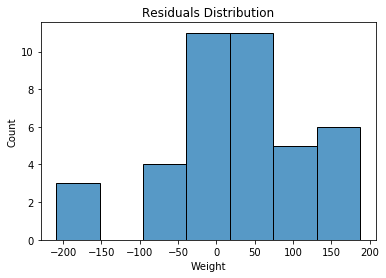

In [26]:
sns.histplot(residuals).set_title('Residuals Distribution');

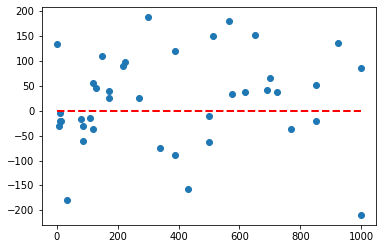

In [27]:
plt.scatter(y_test, residuals)
plt.plot([0, max(y_test)],[0,0],'r--', lw=2);

### We see that the residuals/errors have a distribution that is close to the normal distribution, and that the variance of the errors is fairly constant 